### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from os import listdir, environ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
print(tf.version)
print(tf.config.list_physical_devices('GPU'))

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Nicolas\\anaconda3\\envs\\tensorflow\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
[]


In [2]:
# For reproducible results
seed = 42
environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)  

### Data 

In [3]:
# Constants
val_size = 0.2
data_path = 'public_data.npz'

In [4]:
# Read data
plants = np.load(data_path, allow_pickle=True)
X = plants['data']
y = plants['labels']

# Normalize image pixel values to a float range [0, 1]
X = (X / 255).astype(np.float32)

# Convert labels to categorical format using one-hot encoding
label_encoding = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_encoding[label] for label in y])
y = tfk.utils.to_categorical(y, num_classes=2)

# Split into train and validation (hidden test set on codalab)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=np.argmax(y,axis=1))

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4160, 96, 96, 3) (1040, 96, 96, 3) (4160, 2) (1040, 2)


### ML

In [5]:
# Model parameters 
input_shape = X.shape[1:] 
output_shape = y.shape[1] 
batch_size = 32         
epochs = 200
dout = 0.2

In [6]:
## Model based on LeNet-5 architecture
# > Expanded receptive field (extra conv. and maxpooling at beginning of FEN)
# > Added dropout layers
# > using ReLU activations
model = tfk.models.Sequential([
    tfkl.Input(shape=input_shape, name='input'),
    tfkl.Conv2D(filters=6, kernel_size=(7,7), padding='same', activation='relu', name='conv1'),   
    tfkl.MaxPooling2D(pool_size=(3,3), name='mp1'),                                              
    tfkl.Conv2D(filters=6, kernel_size=(5,5), padding='valid', activation='relu', name='conv2'),  
    tfkl.MaxPooling2D(pool_size=(2,2), name='mp2'),                                               
    tfkl.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu', name='conv3'),
    tfkl.MaxPooling2D(pool_size =(2,2), name='mp3'),                                              
    tfkl.Flatten(name='flatten'),
    tfkl.Dense(units=120, activation='relu', name='dense1'),
    tf.keras.layers.Dropout(rate=dout),
    tfkl.Dense(units=84, activation='relu', name='dense2'),
    tf.keras.layers.Dropout(rate=dout),
    tfkl.Dense(units=output_shape, activation='softmax', name='Output')
])

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 96, 96, 6)         888       
                                                                 
 mp1 (MaxPooling2D)          (None, 32, 32, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 6)         906       
                                                                 
 mp2 (MaxPooling2D)          (None, 14, 14, 6)         0         
                                                                 
 conv3 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 mp3 (MaxPooling2D)          (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0

In [7]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('mark_II.h5')

Epoch 1/200
130/130 [==============================] - 19s 138ms/step - loss: 0.6574 - accuracy: 0.6250 - val_loss: 0.6412 - val_accuracy: 0.6365
Epoch 2/200
130/130 [==============================] - 23s 178ms/step - loss: 0.6382 - accuracy: 0.6442 - val_loss: 0.6155 - val_accuracy: 0.6702
Epoch 3/200
130/130 [==============================] - 25s 189ms/step - loss: 0.6194 - accuracy: 0.6651 - val_loss: 0.6144 - val_accuracy: 0.6827
Epoch 4/200
130/130 [==============================] - 14s 105ms/step - loss: 0.6084 - accuracy: 0.6820 - val_loss: 0.6253 - val_accuracy: 0.6721
Epoch 5/200
130/130 [==============================] - 14s 109ms/step - loss: 0.5985 - accuracy: 0.6832 - val_loss: 0.5873 - val_accuracy: 0.7038
Epoch 6/200
130/130 [==============================] - 14s 105ms/step - loss: 0.5845 - accuracy: 0.6923 - val_loss: 0.5909 - val_accuracy: 0.6856
Epoch 7/200
130/130 [==============================] - 14s 107ms/step - loss: 0.5633 - accuracy: 0.7084 - val_loss: 0.5808 -

### Evaluation

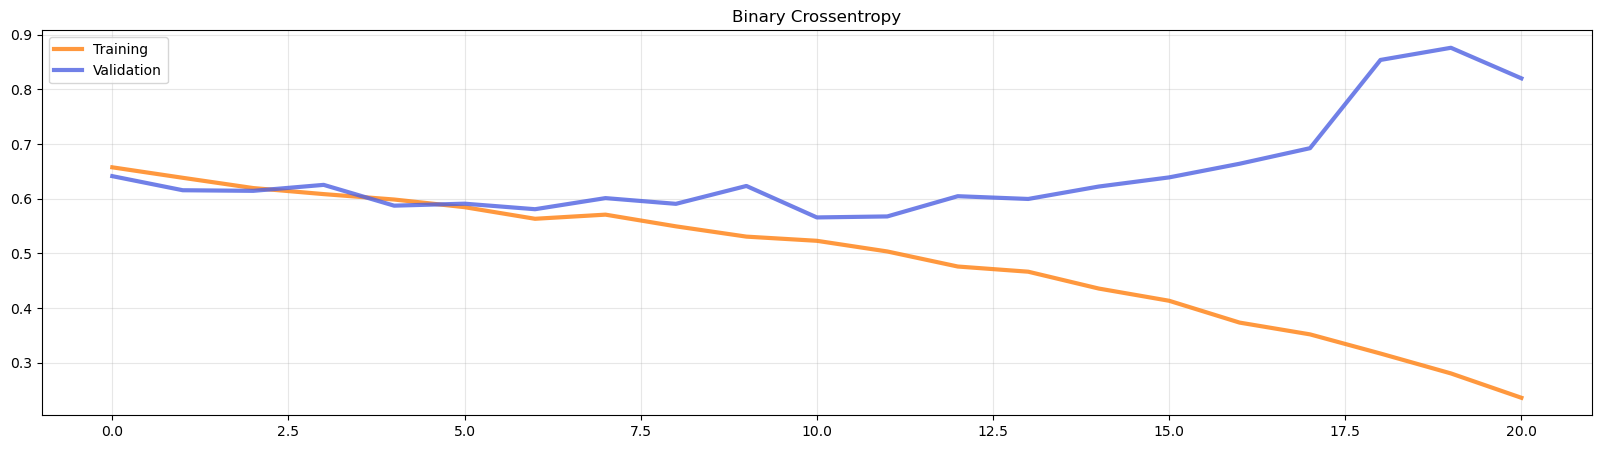

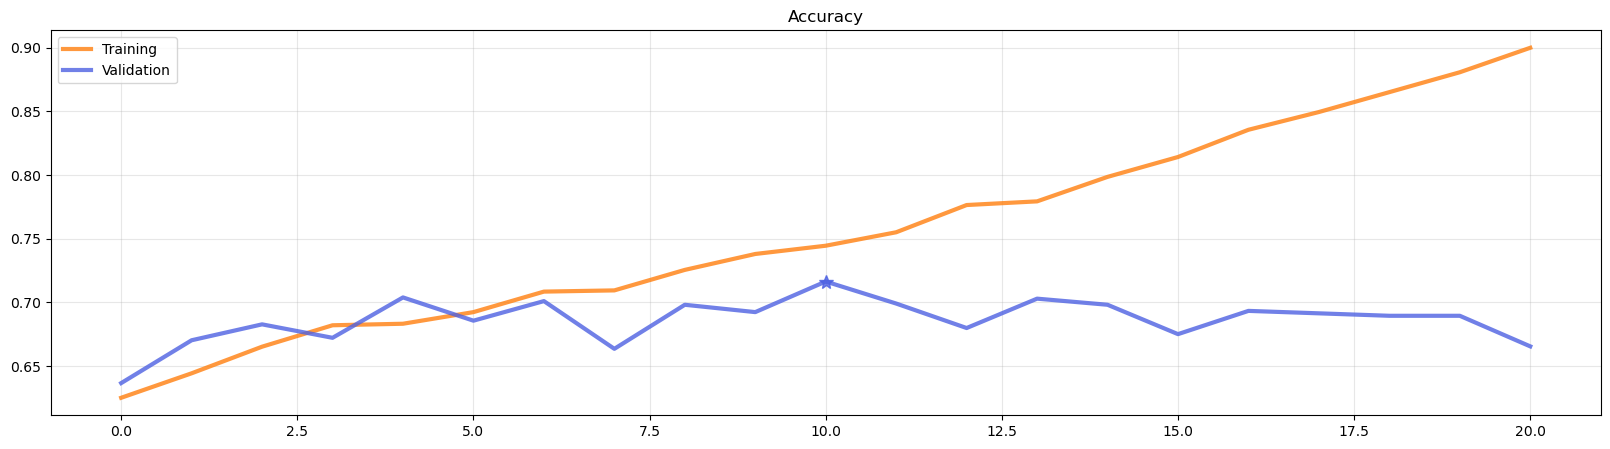

In [8]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [9]:
# Calculate validation accuracy
val_pred = model.predict(X_val, verbose=0)
val_pred = np.argmax(val_pred, axis=-1)
val_true = np.argmax(y_val, axis=-1)
print('Validation accuracy: ', accuracy_score(val_true, val_pred))

Validation accuracy:  0.7163461538461539
